# Confirmation Bias Project
## Behavioural analyses
#### Experiment 2: Control experiment

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

##### Import important functions and libraries

In [2]:
import os, glob
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

##### Important functions

In [3]:
def RT_filter(x, sd): 
    # this function was used to filter those trials with a RT that are above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x #the same dataframe with RT filtered

def log_reg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out #intercept + weight

def z_RT(x):
    # this function was used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function was used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x

### Data & variables

In [4]:
# CAUTION !! 
# Change the current path to the folder where you stored the experimental results 

results_path = r'C:\Users\Angel\Dropbox\ConfBiasProject\Control experiment\data' #control experiment

os.chdir(results_path) # change the current working directory to the results path 
rdata = pd.DataFrame([]) # concatenate general behav subject data
odata = pd.DataFrame([]) # concatenate here orientation stimuli (the matrix containing the 8 orientations x trial)
ddata = pd.DataFrame([]) # concatenate here orientation stimuli transformed to decision variable subject data (the matrix containing the 8 decisionvariables x trial)
ndata = pd.DataFrame([]) # useful when you named wrongly two datasets with the same name
coudf = pd.DataFrame([]) # concatenate files (alternative way to get the number of participants)
n_trials = 40*3 #trials * number of presentations
count = np.zeros(shape=(n_trials, 1)) #count = np.zeros(shape=(1, 1))
for file in glob.glob("*.psydat"): #si estuviera en un working directory por encima puedo hacer "./subject/*.psydat"
    pfile =  open(os.path.join(results_path, file),"rb")
    count = count + 1
    dat = pickle.load(pfile)
    coudf = pd.DataFrame(count, columns = ['npar'])
    for block in dat['main_exp']['Exp_blocks']:
        rdata = pd.concat([rdata,block['data']], axis = 0) #esta función es la que llena el dataframe con los valores de data
        odata = pd.concat([odata,block['trial_orientations']], axis = 0)
        ddata = pd.concat([ddata,pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])], axis = 0)
        ndata = pd.concat([ndata, coudf], axis = 0) #it provides the real number of participants (one file = one participant)
all_df = pd.concat([ndata, rdata, ddata, odata], axis = 1) #otro data frame con todos los data frames que interesan
all_df.tail()

npar           subj  nblock  ntrial  nrep  cond   DV resp  r_map  \
115  27.0  060521130004E       5      38     1    -1 -0.4    m     45   
116  27.0  060521130004E       5      38     2    -1 -0.4    m     45   
117  27.0  060521130004E       5      39     0     1  0.4    m      0   
118  27.0  060521130004E       5      39     1     1  0.4    z     45   
119  27.0  060521130004E       5      39     2     1  0.4    z     45   

     correct     RT        d1        d2        d3        d4        d5  \
115        1  0.649 -0.524327 -0.074119 -0.962840  0.290546 -0.848249   
116        1 -0.031 -0.582896 -0.901206  0.679639 -0.517206 -0.917003   
117        1  0.383  0.219763 -0.275291  0.894062 -0.167301  0.830400   
118        1  0.142  0.154074  0.644507  0.986254  0.434186  0.289037   
119        1  0.324  0.040473  0.435177  0.990309  0.357273 -0.441802   

           d6     o1     o2     o3     o4     o5     o6  
115 -0.368473  1.384  2.778  3.127  1.064  3.082  0.248  
116 -0.254919  1.407  1.532  2.482  2.952  3.109  2.849  
117  0.827335  0.479  2.857  0.827  0.327  0.852  2.424  
118  0.018592  2.024  0.925  0.780  2.134  2.077  0.400  
119  0.934805  2.733  2.578  2.360  0.533  1.790  0.811

### Dataframe experiment 2: coding important variables

In [5]:
# Inserting colums correct, condition and previous condition columns

df = all_df
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df['pre_cond'] = df['cond']
df['pre_cond'] = df['pre_cond'].shift(1, fill_value  = 0)

# Inserting the new necessary columns coding trials properly

df.insert(8, 'deci', 0)

# Criteria to code response type
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
all_df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(10, 'pre_deci', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'pre_correct', 0) # O = incorrect / 1 = correct
df.insert(10, 'rDV', 0) # rDV (real Decision Variable)

# Insert the previous decision of each trial

df['pre_deci']  = df['deci'] 
df['pre_deci'] = df['pre_deci'].shift(1, fill_value  = 0) # 

# Inserting mean DV per trial

df['rDV'] = np.mean(ddata, axis = 1) 

# Insert the previous respose, if correct or not

df['pre_correct'] = df['correct']
df['pre_correct'] = df['pre_correct'].shift(1, fill_value  = 0)

# Insert the first decision in a trial (only to study if the first judgment influences the last presentation)

df.insert(12, 'first_deci', 0)

df['first_deci']  = df['pre_deci'] 
df['first_deci']  = df['first_deci'].shift(1, fill_value  = 0) # decision took 2 presentations earlier

# Inserting columns for the Z score to the previous and two previous decision RT

df = df.groupby(['npar'], group_keys = False).apply(z_RT) 
df.head()

df.insert(13, 'pre_RTz', 0)
df['pre_RTz'] = df['RTz']
df['pre_RTz'] = df['pre_RTz'].shift(1, fill_value  = 0)

df.insert(14, '2pre_RTz', 0)
df['2pre_RTz'] = df['pre_RTz']
df['2pre_RTz'] = df['2pre_RTz'].shift(1, fill_value  = 0)

df.head(10) #10 first outputs

npar           subj  nblock  ntrial  nrep  cond       DV resp  deci  r_map  \
0   1.0  020621150004E       0       0     0     1  0.16667    m     1      0   
1   1.0  020621150004E       0       0     1     1  0.16667    m     0     45   
2   1.0  020621150004E       0       0     2     1  0.16667    m     0     45   
3   1.0  020621150004E       0       1     0     1  0.06667    m     1      0   
4   1.0  020621150004E       0       1     1     1  0.06667    m     1      0   
5   1.0  020621150004E       0       1     2     1  0.06667    z     0      0   
6   1.0  020621150004E       0       2     0     0 -0.01000    z     1     45   
7   1.0  020621150004E       0       2     1     0 -0.01000    z     0      0   
8   1.0  020621150004E       0       2     2     0 -0.01000    z     1     45   
9   1.0  020621150004E       0       3     0     1  0.11000    z     0      0   

        rDV  pre_deci  first_deci   pre_RTz  2pre_RTz  pre_correct  correct  \
0  0.185048         0           0  0.000000  0.000000            0        1   
1  0.159410         1           0  1.237713  0.000000            1        0   
2  0.178250         0           1  3.783534  1.237713            0        0   
3  0.050171         0           0  0.875352  3.783534            0        1   
4  0.089799         1           0  0.889289  0.875352            1        1   
5  0.049998         1           1 -0.118819  0.889289            1        0   
6  0.005765         0           1 -0.913227 -0.118819            0        0   
7  0.007219         1           0  1.524195 -0.913227            0        1   
8 -0.016713         0           1 -0.577191  1.524195            1        0   
9  0.132594         1           0 -0.213281 -0.577191            0        0   

      RT        d1        d2        d3        d4        d5        d6     o1  \
0  1.646 -0.022671  0.566085 -0.622602  0.398017  0.095505  0.695955  1.187   
1  3.290  0.502941  0.061363  0.851290 -0.801375  0.147943  0.194299  2.161   
2  1.412  0.711753  0.784045 -0.302265 -0.435200  0.583391 -0.272226  2.243   
3  1.421  0.066975 -0.660800  0.452012  0.134692  0.851809 -0.543662  0.419   
4  0.770 -0.063414  0.780508  0.771831 -0.761668 -0.717859  0.529397  1.203   
5  0.257 -0.977082  0.201938  0.505488 -0.185127 -0.104677  0.859448  0.009   
6  1.831 -0.481037  0.713262 -0.157115 -0.063414  0.308372 -0.285477  1.367   
7  0.474 -0.134197 -0.171876 -0.182062 -0.321127  0.454558  0.398017  0.340   
8  0.709  0.322141 -0.286467  0.089893 -0.984202  0.983707 -0.225352  2.090   
9  0.842 -0.868620  0.951122  0.716846  0.482569  0.454558 -0.940912  3.090   

      o2     o3     o4     o5     o6  pre_cond       RTz     1/RTz  
0  0.615  1.719  0.549  2.001  0.666         0  1.237713 -0.274395  
1  1.154  0.727  0.078  1.120  0.469         1  3.783534 -0.371568  
2  2.441  0.274  1.349  0.949  1.285         1  0.875352 -0.242168  
3  1.704  2.141  2.696  2.298  1.750         1  0.889289 -0.243604  
4  2.270  0.875  3.048  1.460  2.541         1 -0.118819 -0.053160  
5  0.472  2.162  0.320  2.790  2.301         1 -0.913227  0.776621  
6  0.898  0.331  1.203  1.057  2.861         1  1.524195 -0.294043  
7  1.896  1.892  2.875  2.142  0.549         0 -0.577191  0.206433  
8  1.851  0.428  1.577  0.779  1.875         0 -0.213281 -0.017395  
9  2.337  2.245  2.153  2.142  1.594         0 -0.007323 -0.088707

### Removing bad participants

In [6]:
print(np.unique(df.npar))
print( )
print("n subjects = " + str(len(np.unique(df.npar))))
print( )
print(list(df.columns))

# We removed the participants with negative or very low weight.

formula = "deci ~ rDV"
log_par = df.groupby(['npar']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)

good_weight = log_par.loc[log_par.weight > 0.05, : ].npar #It computes weight. Participants with a negative weight were removed

df = df[df['npar'].isin(good_weight)]
print(pd.unique(df.npar))
df.reset_index(drop=True, inplace=True)

print( )
print("n good participants = " + str(len(good_weight)))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]

n subjects = 27

['npar', 'subj', 'nblock', 'ntrial', 'nrep', 'cond', 'DV', 'resp', 'deci', 'r_map', 'rDV', 'pre_deci', 'first_deci', 'pre_RTz', '2pre_RTz', 'pre_correct', 'correct', 'RT', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'pre_cond', 'RTz', '1/RTz']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]

n good participants = 27


In [7]:
# We decided to remove all participants with very low weights (2 sd below mean),
# becuase they were very naive doing the task.

formula = "deci ~ rDV"
log_par = df.groupby(['npar']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)

mean = np.mean(log_par.weight, axis=0)
print('mean weight by all participants is ' + str(mean))
sd = np.std(log_par.weight, axis=0)
print('std for weight by all participants is ' + str(sd))

good_weight_sd = [x for x in log_par.weight if (x > mean - 2 * sd)]
print(good_weight_sd) #participant 12 was removed because her weight was longer than -2 sd
print("n subjects = " + str(len(np.unique(good_weight_sd))))

mean weight by all participants is 5.441050465610528
std for weight by all participants is 1.6240641120544042
[4.994680522401492, 5.280951486519085, 5.130129033534226, 6.804215886300103, 6.108534028123467, 6.559304880782506, 7.047308100677494, 5.939073633133562, 5.46147830765703, 5.288496700842524, 5.775154062981859, 5.863563766514462, 4.184782685909116, 8.428213701080741, 4.465480929075442, 2.3754039141306458, 5.064723047300214, 5.790246574898056, 6.922895386003705, 5.608749442043267, 8.176243377337872, 6.088242397909871, 4.5797553666215185, 6.282554994186517, 5.462338688524559, 2.6613782222148705]
n subjects = 26


In [8]:
# data frame with weight for all participants
log_par.tail()

npar  level_1  intercept    weight       PSE
22  23.0        0  -0.584821  4.579755  0.127697
23  24.0        0   0.489186  6.282555 -0.077864
24  25.0        0   1.033854  0.564463 -1.831569
25  26.0        0   0.675866  5.462339 -0.123732
26  27.0        0   0.619540  2.661378 -0.232789

In [9]:
df = df.loc[df.npar != 18,:]     #removed because not followed the instructions: counted

df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

##### Dataset with good participants

In [10]:
# Final n after removing bad participants:
print("Subjects in the final dataset = " + str(len(np.unique(df.npar))))
print(np.unique(df.npar)) # those are the particiapnts that remain in the data anlyses

Subjects in the final dataset = 26
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19.
 20. 21. 22. 23. 24. 25. 26. 27.]


In [11]:
estimations = (np.max(np.unique(df.ntrial)) + 1)* (np.max(np.unique(df.nblock)) + 1)
print("number of trials by participant was " + str(estimations))

number of trials by participant was 240


### RTs 
##### Filter those responses with RTs larger than 3 sd

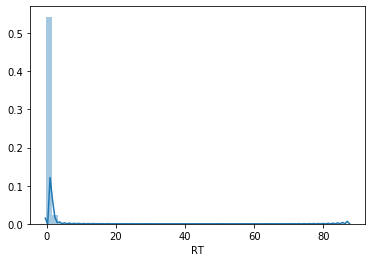

In [12]:
sns.axes_style('white') #RTs
sns.distplot(df.RT)

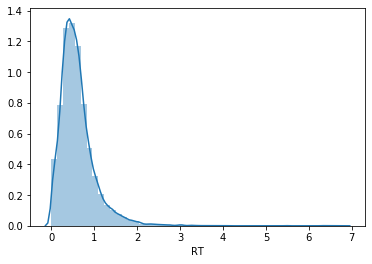

In [13]:
# RTs after apply filter
df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 3)
sns.distplot(df.RT)

###### The original dataset was transformed to long format to perform some of the necessary analyses
 - It allows to perform reverse correlation analyses
 - We inserted new variables to this dataset

In [14]:
# new dataframe, it measures the particular effect by each stimuli position.
# it allows to measure the effect of each particular stimuli position in the final choice
# and to estimate if previous stimuli affect the final decision

# df to long format
dflong = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep', 'deci','pre_deci', 'pre_correct', 'correct', 'first_deci', 'pre_cond', 'RT', 'RTz', 'pre_RTz'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci', 'pre_cond', 'RT', 'RTz', 'pre_RTz'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
del out

dflong.insert(6, 'expected', "U") 
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong.pre_deci == 0) & (dflong.dv < 0) | (dflong.pre_deci == 1) & (dflong.dv > 0), "expected"]  = "E"

dflong.insert(4, 'cond', "D")
dflong.loc[(dflong.dv < 0), "cond"]  = "C"

dflong["pre_cond"].replace({0: "C", 1: "D"}, inplace=True)
dflong.insert(7, 'cong_stim', 'I')
dflong.loc[(dflong.pre_cond == 'C') & (dflong.cond == 'C') | (dflong.pre_cond == 'D') & (dflong.cond == 'D'), 'cong_stim'] = 'C'

dflong.insert(7, 'cong_deci', 'I')
dflong.loc[(dflong.pre_deci == 0) & (dflong.cond == 'C') | (dflong.pre_deci == 1) & (dflong.cond == 'D'), 'cong_deci'] = 'C'

dflong.insert(8, 'pre_expected', "U")
dflong['pre_expected'] = dflong['expected']
dflong['pre_expected'] = dflong['pre_expected'].shift(1, fill_value = "U")

dflong.insert(9, 'cong_long', 0)
# one participant is congruent when the 2 last pre decis and deci variable were the same 
dflong.loc[(dflong.expected == 'U') & (dflong.pre_expected == 'U') | (dflong.expected == 'E') & (dflong.pre_expected == 'E'), 'cong_long'] = 1
#bins <- divids the orientation of the stimuli in small categories. it groups similar oriented stimuli together
dflong['bins'] = pd.cut(x=dflong['dv'], bins=[-0.99, -0.33, 0.33, 0.99], labels=[-0.60, 0, 0.60])

dflong.insert(17, '1/RT', 0)
dflong['1/RT'] = 1/dflong['RT']

print(dflong.head())

formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)

   npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    C     1         0         C            U   
1   1.0       0       0     2    D     0         0         I            E   
2   1.0       0       1     0    D     1         0         I            U   
3   1.0       0       1     1    C     1         1         I            U   
4   1.0       0       1     2    C     0         1         I            U   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          0         C        E            0        1           0        C   
1          0         C        U            0        0           1        D   
2          1         C        U            0        1           0        D   
3          1         I        U            1        1           0        D   
4          1         I        U            1        0           1        D   

      RT      1/RT       RTz   pre_RTz stim        dv  orient bins  

### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [15]:
# In this chunk, we will compute two important things. We will group stimuli depending on their similar orientation
# compared with the orientation of the previous stimuli and also, we will group stimuli depending on the previous
# category. Two stimuli would be grouped together if they were preceded by a stimuli from the same category (Diag follwd Diag)

# selecting the stimuli DV
stim_dec = df[['d1','d2','d3','d4','d5','d6']]
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0

diff_stim_dec = np.diff(stim_dec, axis  = 1)
out = abs(pd.DataFrame(diff_stim_dec, index = df.index, columns = ["cd2","cd3","cd4","cd5","cd6"]))

# resetting indexes in order to be able to concatenate the dataframes 
out.reset_index(drop=True, inplace=True)

# concatenating vertically (over columns)
df.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=['cd2', 'cd3', 'cd4', 'cd5', 'cd6'])
out.head()

# dataset removing first stimulus of the sequence in order to append whether the previous stim is congruent or incongruent
dflong_sd = dflong.loc[dflong.stim != "d1", : ]
dflong_sd.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
dflong_sd = pd.concat([dflong_sd, out.value], axis = 1)

dflong_sd.rename(columns = {'value' : 'pre_stim'}, inplace = True)

#Appending information about the physical difference between the pre-stimulus and current orientation (classifyin in similar & different physically)

stim_ori = df[['o1','o2','o3','o4','o5','o6']]

diff_stim_ori = abs(np.diff(np.rad2deg(stim_ori), axis  = 1))
diff_stim_ori[diff_stim_ori < 67.5] = 0
diff_stim_ori[diff_stim_ori > 67.5] = 1
diff_stim_ori
out = abs(pd.DataFrame(diff_stim_ori, columns = ["co2","co3","co4","co5","co6"]))

# concatenating vertically (over columns)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=["co2","co3","co4","co5","co6"])
out.rename(columns = {'value' : 'pre_orient'}, inplace = True) # if the difference is smaller than 67.5 degrees the stimuli are assumed to be similar

dflong_sd = pd.concat([dflong_sd, out.pre_orient], axis = 1)
dflong_sd.head()

C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Angel\Anaconda3\lib\site-packages\pandas\core\frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    D     1         0         I            E   
1   1.0       0       0     2    D     0         0         I            U   
2   1.0       0       1     0    C     1         0         C            U   
3   1.0       0       1     1    D     1         1         C            E   
4   1.0       0       1     2    D     0         1         C            E   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          0         I        U            0        1           0        C   
1          1         C        U            0        0           1        D   
2          0         I        E            0        1           0        D   
3          1         C        E            1        1           0        D   
4          1         C        E            1        0           1        D   

      RT      1/RT       RTz   pre_RTz stim        dv  orient bins  pre_stim  \
0  1.646  0.607533  1.237713  0.000000   d2  0.566085   0.615  0.6       1.0   
1  1.412  0.708215  0.875352  3.783534   d2  0.784045   2.441  0.6       0.0   
2  1.421  0.703730  0.889289  0.875352   d2 -0.660800   1.704 -0.6       1.0   
3  0.770  1.298701 -0.118819  0.889289   d2  0.780508   2.270  0.6       1.0   
4  0.257  3.891051 -0.913227 -0.118819   d2  0.201938   0.472  0.0       1.0   

   pre_orient  
0         0.0  
1         0.0  
2         1.0  
3         0.0  
4         0.0

## Plots experiment 1

<font size="5"> _Figure 2A. Logistic regression fit for each presentation._

Repeating the same sequence of stimuli makes the participants' estimation more similar to the real average of the sequence?

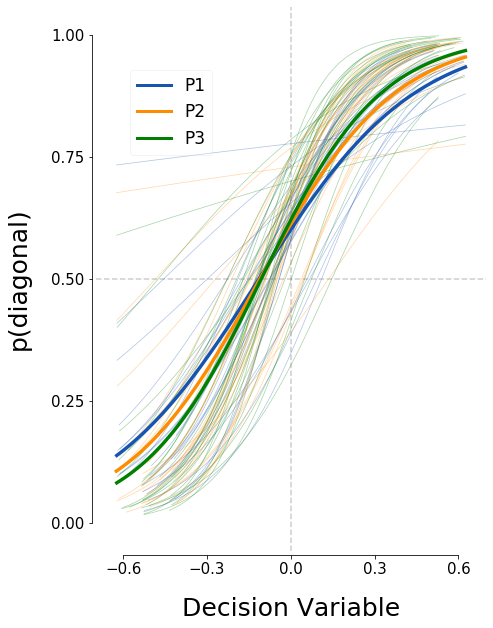

In [124]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                         line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                     line_kws ={'lw':3.4});
    
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.savefig('deci_x_nrep.png',bbox_inches='tight')

<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with number of presentation

In [17]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

npar  nrep  level_2  intercept    weight       PSE
73  26.0     1        0   0.792800  6.194366 -0.127987
74  26.0     2        0   0.774007  6.097062 -0.126948
75  27.0     0        0   0.642714  2.147679 -0.299260
76  27.0     1        0   0.718977  2.670655 -0.269214
77  27.0     2        0   0.462065  3.131632 -0.147548

<font size="4"> _Statistical tests for Weight._

In [18]:
# Means in weight for presentation

dat = log_reg_nrep.loc[log_reg_nrep.nrep == 0,:] # without pre_deci as a factor
print('Weight mean at P1: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 1,:] # without pre_deci as a factor
print('Weight mean at P2: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 2,:] # without pre_deci as a factor
print('Weight mean at P3: ')
print(np.mean(dat.weight))

Weight mean at P1: 
4.717889207561639
Weight mean at P2: 
5.446229762734536
Weight mean at P3: 
6.2274205544446


In [19]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

Source         SS  DF         MS          F         p-unc     p-GG-corr  \
0   nrep  29.635007   2  14.817504  22.751775  9.413739e-08  3.358647e-07   
1  Error  32.563401  50   0.651268        NaN           NaN           NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.476459  0.902738       True  0.892259  0.254618  
1       NaN       NaN        NaN       NaN       NaN

In [20]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -3.375331  25.0  two-sided  0.002410   
1     nrep  0  2    True        True -5.885972  25.0  two-sided  0.000004   
2     nrep  1  2    True        True -4.009689  25.0  two-sided  0.000483   

     p-corr p-adjust      BF10     cohen  
0  0.007231     bonf    15.948 -0.419049  
1  0.000012     bonf  5159.104 -0.823820  
2  0.001450     bonf    65.332 -0.404769

In [21]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'intercept', within = ['nrep'], subject = 'npar', data=log_reg_nrep, 
            detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep  0.227027   2  0.113513  4.739051  0.013041   0.017693  0.159354   
1  Error  1.197638  50  0.023953       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.860875       True  0.838392  0.120604  
1       NaN        NaN       NaN       NaN

<font size="2"> _t-test showed significant differences in weight in the third presentation compared with previous presentations._

<font size="4"> _Statistical tests for PSE._

In [22]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'PSE', within = ['nrep'], subject = 'npar', 
            data=log_reg_nrep, detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep  0.100699   2  0.050349  1.044412  0.359448    0.31712  0.040101   
1  Error  2.410420  50  0.048208       NaN       NaN        NaN       NaN   

        eps sphericity    W-spher  p-spher  
0  0.503755       True  41.642329      1.0  
1       NaN        NaN        NaN      NaN

In [23]:
pg.pairwise_ttests(dv='PSE', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.039684  25.0  two-sided  0.308438   
1     nrep  0  2    True        True -1.025318  25.0  two-sided  0.315033   
2     nrep  1  2    True        True -1.006185  25.0  two-sided  0.323967   

     p-corr p-adjust   BF10     cohen  
0  0.925315     bonf  0.337 -0.060778  
1  0.945098     bonf  0.333 -0.182863  
2  0.971900     bonf  0.327 -0.142728

<font size="2"> _t-test showed significant differences in PSE between the initial and final presentations._

<font size="5"> _Figure 2B. Beta weight for each presentation._

In [24]:
fig = go.Figure()

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_nrep
fig.add_trace(go.Scatter( #lineplot for different category
    y=dat['weight'], x=dat['nrep'], line=dict(color='#C6C2C2', width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.6, 
    pointpos=0,
        marker=dict(color='#2A88D4',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.6, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, ))

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [0,2,4,6,8, 10], ticktext=['0', '2', '4', '6', '8', '10'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(
    yaxis_title="Beta Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_traces(showlegend=False)

fig['layout']['yaxis'].update(range=[-0.01, 10.02]);
fig.show()

<font size="5"> _Figure 2C. PSE for each presentation._

In [25]:
fig = go.Figure()

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_nrep
fig.add_trace(go.Scatter( #lineplot for different category
    y=dat['PSE'], x=dat['nrep'],
    line=dict(color='#C6C2C2', width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4',size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [-1, -0.75,-.60, -.45,-.30,-.15, 0, .15], 
                 ticktext=['-1','-0.75','-0.60', '-0.45','-0.30','-0.15', '0', '0.15'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_traces(showlegend=False)

fig['layout']['yaxis'].update(range=[-0.602, 0.162]);

fig.show()

<font size="5"> _Figure 3A. Logistic regression fits for each presentation separated by cardinal & diagonal._

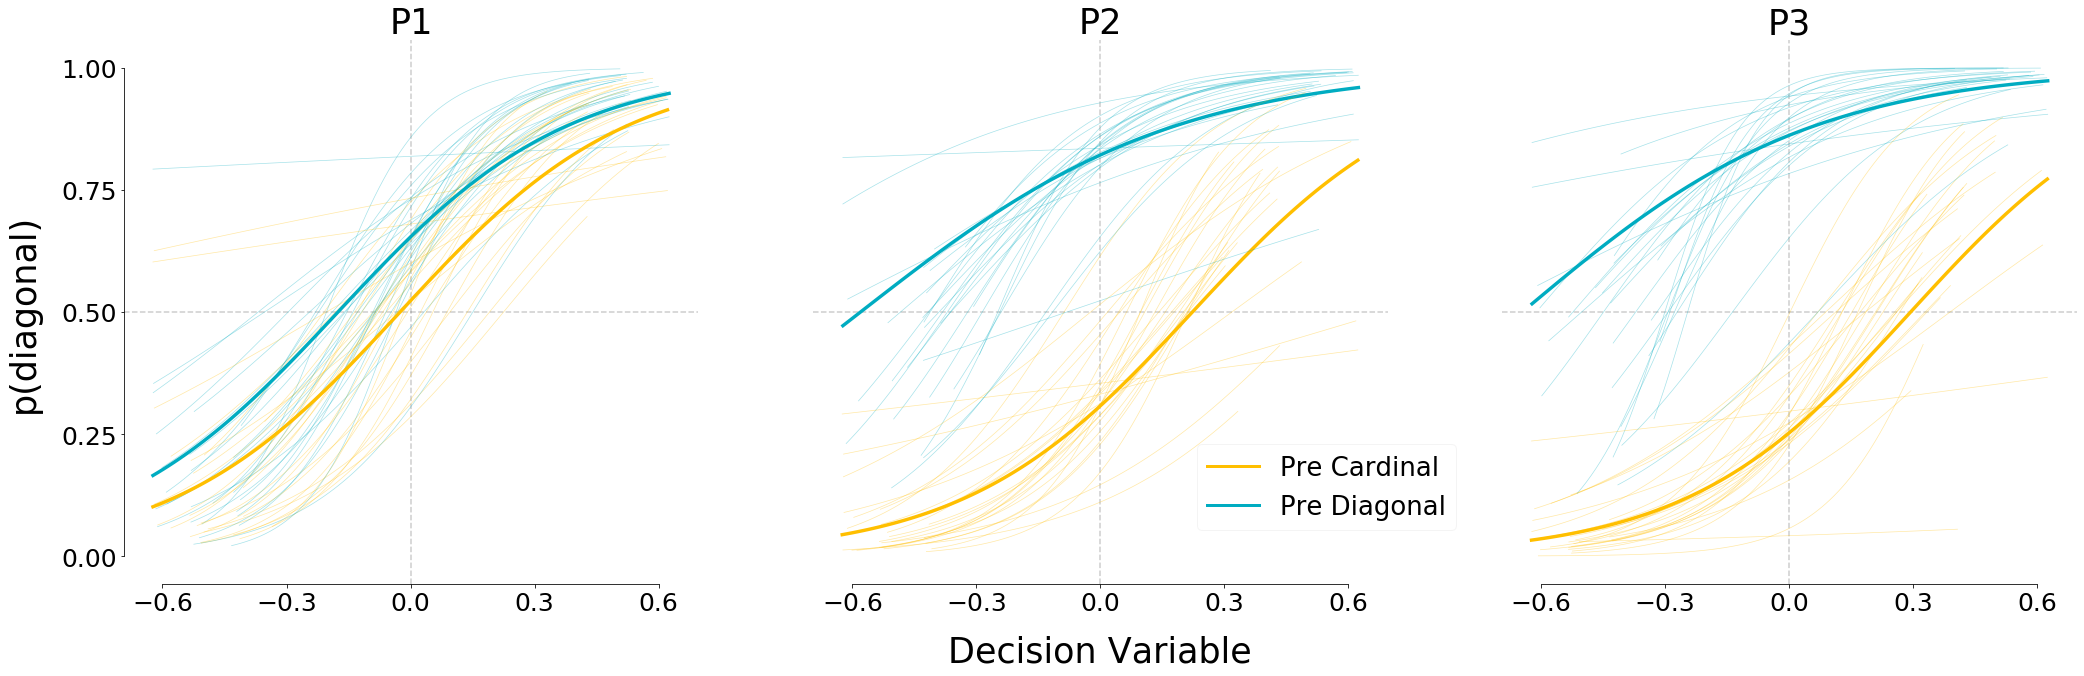

In [26]:
# Previous decisions biases the next response? Previous decision might bias how we estimate the next presentation
# of the trial. Let's find out if previous cardinal decision generates different probabilities to answer diagonal 
# compared with when they previously responded diagonal to equivalent sequences

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
plt.subplots(ncols=2, figsize=(35, 10))

#mycol = ["#ffbf00", '#70C1B3'] #cardinal #diagonal
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal

sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)

plt.subplot(1, 3, 1)
ax0 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax0 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P1
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax0 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 0),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                          label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average for P1
    ax0 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 0),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                      label=cell, truncate=True, line_kws={'lw':3.4}); 
sns.despine(ax= ax0, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 35, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); 
plt.title('P1', fontsize= 35); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; 

plt.subplot(1, 3, 2)
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P2
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 1),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, 
                      ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4});   
for i in npar_labels: #this for loop makes the plot for each participant for P2
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 1),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                          line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax1, offset=0, trim=True);
sns.despine(ax=ax1, left=True)
plt.xlabel('Decision Variable', fontdict={'size':35}, labelpad=20); 
plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); plt.title('P2', fontsize= 35); 
plt.yticks([], []); plt.ylabel('', fontsize = 0)
plt.legend(lines, labels, bbox_to_anchor=(0.645,0.075), fontsize=26, framealpha= 0.2)

plt.subplot(1, 3, 3)
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P3
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, 
                      line_kws={'lw':3.4}); 
for i in npar_labels: #this for loop makes the plot for each participant for P3
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                          line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True)
plt.title('P3', fontsize=35); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
plt.yticks([], []); plt.xlabel(' ', fontsize = 0); plt.ylabel('', fontsize = 0)
plt.savefig('predeci.png')

<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with previous decision by each presentation

In [27]:
formula = "deci ~ rDV"
log_reg_preDeci = df.groupby(['npar', 'nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(6)

npar  nrep  pre_deci  level_3  intercept    weight       PSE
0   1.0     0         0        0   0.234699  3.960254 -0.059264
1   1.0     0         1        0   0.372516  4.230485 -0.088055
2   1.0     1         0        0  -2.084425  3.663101  0.569033
3   1.0     1         1        0   1.854667  4.474912 -0.414459
4   1.0     2         0        0  -2.811486  7.854586  0.357942
5   1.0     2         1        0   2.427713  3.972083 -0.611194

<font size="4"> Statistical tests for Weight

In [28]:
dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 0,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 1,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 2,:] # with pre_deci as a factor
print(np.mean(dat.weight))

4.903404440568006

4.3564272378040405

4.719864166669007


In [29]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0             nrep  8.059263      2     50  4.029632  1.666394  0.199247   
1         pre_deci  0.575424      1     25  0.575424  0.215674  0.646375   
2  nrep * pre_deci  8.783420      2     50  4.391710  1.830834  0.170862   

   p-GG-corr       np2       eps  
0   0.201208  0.062490  0.938811  
1   0.646375  0.008553  1.000000  
2   0.175772  0.068236  0.886884

In [30]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
pg.pairwise_ttests(dv='weight', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf',
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

Contrast nrep  A  B Paired  Parametric         T   dof       Tail  \
0             nrep    -  0  1   True        True  1.979300  25.0  two-sided   
1             nrep    -  0  2   True        True  0.538901  25.0  two-sided   
2             nrep    -  1  2   True        True -1.234617  25.0  two-sided   
3         pre_deci    -  0  1   True        True -0.464407  25.0  two-sided   
4  nrep * pre_deci    0  0  1   True        True -1.297483  25.0  two-sided   
5  nrep * pre_deci    1  0  1   True        True  1.621659  25.0  two-sided   
6  nrep * pre_deci    2  0  1   True        True -0.788268  25.0  two-sided   

      p-unc    p-corr p-adjust   BF10     cohen  
0  0.058895  0.176686     bonf   1.11  0.331822  
1  0.594722  1.000000     bonf  0.237  0.103427  
2  0.228452  0.685357     bonf   0.41 -0.216423  
3  0.646375       NaN      NaN  0.229 -0.076305  
4  0.206311  0.618932     bonf  0.439 -0.233220  
5  0.117422  0.352266     bonf  0.656  0.310451  
6  0.437951  1.000000     bonf  0.275 -0.195766

<font size="2"> _t-test showed significantly that previous choices reduced discriminability from P1 to P2 and from P1 to P3._

<font size="4"> Statistical tests for PSE

In [31]:
df.reset_index(drop=True, inplace=True) # function resets the row indexes of the pandas dataframe
pg.rm_anova(dv = 'PSE', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS          F     p-unc  \
0             nrep   1.213499      2     50   0.606750   1.594482  0.213163   
1         pre_deci  18.591270      1     25  18.591270  11.050187  0.002737   
2  nrep * pre_deci   4.372771      2     50   2.186385   7.170357  0.001829   

   p-GG-corr       np2       eps  
0   0.219015  0.059955  0.537945  
1   0.002737  0.306522  1.000000  
2   0.003851  0.222887  0.808272

In [32]:
pg.pairwise_ttests(dv='PSE', within= ['pre_deci', 'nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

Contrast pre_deci  A  B Paired  Parametric         T   dof  \
0         pre_deci        -  0  1   True        True  3.324182  25.0   
1             nrep        -  0  1   True        True -0.447646  25.0   
2             nrep        -  0  2   True        True -1.294403  25.0   
3             nrep        -  1  2   True        True -1.257967  25.0   
4  pre_deci * nrep        0  0  1   True        True -3.023923  25.0   
5  pre_deci * nrep        0  0  2   True        True -2.939124  25.0   
6  pre_deci * nrep        0  1  2   True        True -1.330980  25.0   
7  pre_deci * nrep        1  0  1   True        True  4.429896  25.0   
8  pre_deci * nrep        1  0  2   True        True  1.045638  25.0   
9  pre_deci * nrep        1  1  2   True        True -0.684626  25.0   

        Tail     p-unc    p-corr p-adjust    BF10     cohen  
0  two-sided  0.002737       NaN      NaN  14.287  0.974278  
1  two-sided  0.658264  1.000000     bonf   0.227 -0.023133  
2  two-sided  0.207356  0.622067     bonf   0.437 -0.335844  
3  two-sided  0.220027  0.660081     bonf    0.42 -0.334081  
4  two-sided  0.005700  0.034203     bonf   7.602 -1.093580  
5  two-sided  0.006986  0.041915     bonf   6.393 -0.836136  
6  two-sided  0.195207  1.000000     bonf   0.456 -0.310967  
7  two-sided  0.000163  0.000980     bonf   171.8  0.258240  
8  two-sided  0.305733  1.000000     bonf   0.339  0.209892  
9  two-sided  0.499878  1.000000     bonf   0.257 -0.148073

In [33]:
dat =log_reg_preDeci.loc[log_reg_preDeci.nrep == 0]
pg.pairwise_ttests(dv='PSE', within= ['pre_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0  pre_deci  0  1    True        True  1.311704  25.0  two-sided  0.201539   

    BF10     cohen  
0  0.446  0.269893

In [34]:
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1]
pg.ttest(dat['PSE'], 0)

T  dof       tail     p-val           CI95%   cohen-d     BF10  \
T-test -4.267645   77  two-sided  0.000056  [-0.75, -0.27]  0.483216  344.257   

           power  
T-test  0.987898

In [35]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 0] #cardinal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -3.023923  25.0  two-sided  0.005700   
1     nrep  0  2    True        True -2.939124  25.0  two-sided  0.006986   
2     nrep  1  2    True        True -1.330980  25.0  two-sided  0.195207   

     p-corr p-adjust   BF10     cohen  
0  0.017101     bonf  7.602 -1.093580  
1  0.020957     bonf  6.393 -0.836136  
2  0.585622     bonf  0.456 -0.310967

In [36]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1] #diagonal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True  4.429896  25.0  two-sided  0.000163   
1     nrep  0  2    True        True  1.045638  25.0  two-sided  0.305733   
2     nrep  1  2    True        True -0.684626  25.0  two-sided  0.499878   

    p-corr p-adjust   BF10     cohen  
0  0.00049     bonf  171.8  0.258240  
1  0.91720     bonf  0.339  0.209892  
2  1.00000     bonf  0.257 -0.148073

<font size="2"> post-hoc t-test showed:
    
    
<font size="2"> 1. _PSE in Cardinal condition: PSE displacement in P2 and P3 was significant compared with the PSE in P1._ 
    
<font size="2"> 2. _PSE in Diagonal condition: PSE displacement in P3 was significant compared with the PSE in P1._

<font size="5"> _Figure 3B. Beta weight by presentation and condition._

In [37]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=  "#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal', marker_color= '#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   ))


fig['layout']['yaxis'].update(range=[-10.05, 20.05]);

fig.show()

<font size="5"> _Figure 3C. PSE by presentation and condition._

In [38]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color="#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box(y=dat['PSE'],x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal',marker_color='#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig['layout']['yaxis'].update(range=[-2.01, 2.01]);

fig.show()

<font size="5"> _Figure 4A. Beta Weight by presentation and sample._

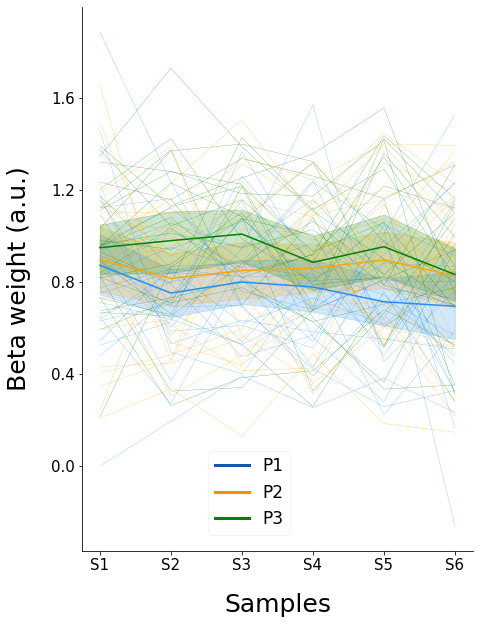

In [39]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="weight", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Weight', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="weight", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

ind = ind = np.arange(6)
plt.ylabel('Beta weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.3,0.2), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
#plt.savefig('sample_weight4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Weight

In [40]:
# ANOVA to check if weight depends on the position of the stimuli sample: recency and primacy bias

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS          F         p-unc  \
0         nrep  2.161085      2     50  1.080543  22.654803  9.904515e-08   
1         stim  0.684494      5    125  0.136899   1.424766  2.198529e-01   
2  nrep * stim  0.547778     10    250  0.054778   0.850499  5.804636e-01   

      p-GG-corr       np2       eps  
0  6.943572e-07  0.475394  0.850625  
1  2.333374e-01  0.053918  0.763969  
2  5.197288e-01  0.032901  0.517833

In [41]:
# post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=False, data=log_regstim_params) 

Contrast   A   B  Paired  Parametric         T   dof       Tail     p-unc  \
0      nrep   0   1    True        True -3.302862  25.0  two-sided  0.002885   
1      nrep   0   2    True        True -6.066044  25.0  two-sided  0.000002   
2      nrep   1   2    True        True -4.096274  25.0  two-sided  0.000387   
3      stim  d1  d2    True        True  1.303733  25.0  two-sided  0.204203   
4      stim  d1  d3    True        True  0.332861  25.0  two-sided  0.742014   
5      stim  d1  d4    True        True  1.163059  25.0  two-sided  0.255787   
6      stim  d1  d5    True        True  0.840768  25.0  two-sided  0.408448   
7      stim  d1  d6    True        True  2.107050  25.0  two-sided  0.045315   
8      stim  d2  d3    True        True -0.937501  25.0  two-sided  0.357470   
9      stim  d2  d4    True        True  0.209376  25.0  two-sided  0.835851   
10     stim  d2  d5    True        True -0.111398  25.0  two-sided  0.912190   
11     stim  d2  d6    True        True  1.415100  25.0  two-sided  0.169376   
12     stim  d3  d4    True        True  1.188368  25.0  two-sided  0.245855   
13     stim  d3  d5    True        True  0.585055  25.0  two-sided  0.563755   
14     stim  d3  d6    True        True  1.807759  25.0  two-sided  0.082692   
15     stim  d4  d5    True        True -0.277194  25.0  two-sided  0.783911   
16     stim  d4  d6    True        True  1.299965  25.0  two-sided  0.205472   
17     stim  d5  d6    True        True  1.540638  25.0  two-sided  0.135968   

      p-corr p-adjust      BF10     cohen  
0   0.008654     bonf     13.65 -0.478006  
1   0.000007     bonf  7829.223 -0.914132  
2   0.001160     bonf    79.609 -0.357778  
3   1.000000     bonf     0.442  0.237813  
4   1.000000     bonf     0.218  0.081851  
5   1.000000     bonf      0.38  0.271654  
6   1.000000     bonf     0.286  0.204418  
7   0.679722     bonf     1.365  0.470932  
8   1.000000     bonf     0.308 -0.157189  
9   1.000000     bonf     0.211  0.035868  
10  1.000000     bonf     0.208 -0.021456  
11  1.000000     bonf     0.503  0.265896  
12  1.000000     bonf      0.39  0.191850  
13  1.000000     bonf     0.242  0.127297  
14  1.000000     bonf     0.854  0.401612  
15  1.000000     bonf     0.215 -0.055065  
16  1.000000     bonf      0.44  0.233468  
17  1.000000     bonf     0.589  0.271176

<font size="2"> _t-test showed that discriminabilty was larger in the third sample than in the first one._

<font size="5"> _Figure 4B. Intercept by presentation and sample._

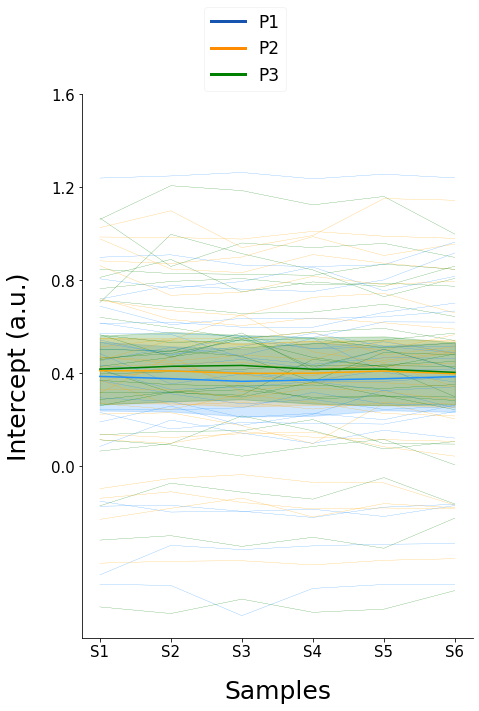

In [42]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)#npar

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="intercept", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="intercept", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Intercept (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
#plt.savefig('sample_intercept4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Inercept

In [43]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS         F     p-unc  \
0         nrep  0.148697      2     50  0.074348  1.114678  0.336034   
1         stim  0.006970      5    125  0.001394  0.781615  0.564766   
2  nrep * stim  0.021313     10    250  0.002131  1.019148  0.427616   

   p-GG-corr       np2       eps  
0   0.328193  0.042684  0.828284  
1   0.545128  0.030317  0.839676  
2   0.346834  0.039169  0.141196

<font size="2"> _There were non statisitcal differences in sample position and intercept._

<font size="5"> _Figure 5 A & B. Category similarity between consecutive samples._

Logisitc regression model with the category of the previous stimuli sample

In [44]:
# First, build a logistic model with presentations and the category of previous sample

formula = "deci ~ dv"

log_regpre_deci_params = dflong_sd.groupby(['npar', 'nrep', 'pre_stim']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

npar  nrep  pre_stim  level_3  intercept    weight       PSE
0   1.0     0       0.0        0   0.233035  1.247558 -0.186793
1   1.0     0       1.0        0   0.240330  0.297472 -0.807906
2   1.0     1       0.0        0   0.151451  1.703279 -0.088917
3   1.0     1       1.0        0   0.097498  0.334069 -0.291850
4   1.0     2       0.0        0   0.059467  1.895026 -0.031380

<font size="5"> _5A. Beta Weight._

In [45]:
fig = go.Figure()
data = log_regpre_deci_params

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd'))

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .75, 1.50, 2.25], ticktext=['0', '0.75', '1.50', '2.25', '1', '1.25'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",size=15, color= "#424242" ))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.18, 2.4])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [46]:
#Checking statistical differences in Weight between the number of repetitions & the previous sample category
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

pg.rm_anova(dv = 'weight', within = ['pre_stim','nrep'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

#Weight was larger in those samples that followed a sample from the same category

Source         SS  ddof1  ddof2         MS           F  \
0         pre_stim  66.855985      1     25  66.855985  521.533706   
1             nrep   0.947587      2     50   0.473793   19.015208   
2  pre_stim * nrep   0.428024      2     50   0.214012    7.751499   

          p-unc     p-GG-corr       np2       eps  
0  2.897783e-18  2.897783e-18  0.954257  1.000000  
1  7.218240e-07  3.989137e-06  0.432014  0.846520  
2  1.168748e-03  3.128554e-03  0.236676  0.770232

Post-hoc t-test

In [47]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['pre_stim','nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  22.837112  25.0  two-sided   
1      nrep  0.0  1.0    True        True  -3.023351  25.0  two-sided   
2      nrep  0.0  2.0    True        True  -5.831432  25.0  two-sided   
3      nrep  1.0  2.0    True        True  -3.529257  25.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  2.897783e-18       NaN      NaN  1.464e+15  5.676654  
1  5.708341e-03  0.017125     bonf      7.593 -0.556137  
2  4.417975e-06  0.000013     bonf   4545.182 -1.030643  
3  1.640479e-03  0.004921     bonf      22.29 -0.376637

In [48]:
# post-hoc t-test for P1
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 0] 
pg.pairwise_ttests(dv='weight', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  20.006014  25.0  two-sided   

          p-unc       BF10    cohen  
0  6.715862e-17  7.261e+13  5.61438

In [49]:
# post-hoc t-test for P2
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 1] 
pg.pairwise_ttests(dv='weight', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  20.078407  25.0  two-sided   

          p-unc       BF10     cohen  
0  6.167333e-17  7.877e+13  4.653782

In [50]:
# post-hoc t-test for P3
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2] 
pg.pairwise_ttests(dv='weight', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  18.000154  25.0  two-sided   

          p-unc       BF10     cohen  
0  7.986953e-16  6.831e+12  4.830964

In [51]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 0]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -3.090615  25.0  two-sided  0.004852   
1     nrep  0  2    True        True -4.790955  25.0  two-sided  0.000064   
2     nrep  1  2    True        True -3.668186  25.0  two-sided  0.001155   

     p-corr p-adjust     BF10     cohen  
0  0.014555     bonf    8.725 -0.543829  
1  0.000192     bonf  398.633 -0.927857  
2  0.003466     bonf    30.29 -0.362194

In [52]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 1]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.182396  25.0  two-sided  0.248173   
1     nrep  0  2    True        True -1.996108  25.0  two-sided  0.056924   
2     nrep  1  2    True        True -0.808959  25.0  two-sided  0.426171   

     p-corr p-adjust   BF10     cohen  
0  0.744518     bonf  0.388 -0.269292  
1  0.170772     bonf   1.14 -0.524051  
2  1.000000     bonf  0.279 -0.213110

<font size="5"> _5B. Intercept._

In [53]:
fig = go.Figure()
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],x=dat['nrep'],boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd')) 

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1, -0.5, 0, 0.5, 1, 1.5], ticktext=['-1', '-0.5', '0', '0.5', '1', '1.5'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15,color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-1.005, 1.505])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, 
              line=dict(color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Inercept

In [54]:
#Checking statistical differences in Intercept between the number of repetitions 
# & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

# no differences in the intercept

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0             nrep  0.062280      2     50  0.031140  1.303363  0.280684   
1         pre_stim  0.085936      1     25  0.085936  5.530461  0.026873   
2  nrep * pre_stim  0.023214      2     50  0.011607  1.311490  0.278525   

   p-GG-corr       np2       eps  
0   0.278023  0.049551  0.807722  
1   0.026873  0.181146  1.000000  
2   0.277239  0.049845  0.873024

In [55]:
pg.pairwise_ttests(dv='intercept', within=['pre_stim', 'nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=log_regpre_deci_params) 

Contrast pre_stim  A  B Paired  Parametric         T   dof  \
0         pre_stim        -  0  1   True        True  2.351693  25.0   
1             nrep        -  0  1   True        True -1.071905  25.0   
2             nrep        -  0  2   True        True -1.320153  25.0   
3             nrep        -  1  2   True        True -0.706551  25.0   
4  pre_stim * nrep        0  0  1   True        True -0.150792  25.0   
5  pre_stim * nrep        0  0  2   True        True -1.026587  25.0   
6  pre_stim * nrep        0  1  2   True        True -1.437047  25.0   
7  pre_stim * nrep        1  0  1   True        True -1.794238  25.0   
8  pre_stim * nrep        1  0  2   True        True -1.285883  25.0   
9  pre_stim * nrep        1  1  2   True        True  0.325508  25.0   

        Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  two-sided  0.026873       NaN      NaN  2.079  0.124315  
1  two-sided  0.294002  0.882005     bonf  0.348 -0.082221  
2  two-sided  0.198744  0.596233     bonf   0.45 -0.123230  
3  two-sided  0.486379  1.000000     bonf   0.26 -0.044094  
4  two-sided  0.881350  1.000000     bonf  0.209 -0.014164  
5  two-sided  0.314446  1.000000     bonf  0.333 -0.123362  
6  two-sided  0.163103  0.978619     bonf  0.517 -0.109085  
7  two-sided  0.084879  0.509273     bonf  0.837 -0.145926  
8  two-sided  0.210267  1.000000     bonf  0.433 -0.118693  
9  two-sided  0.747505  1.000000     bonf  0.218  0.023193

In [56]:
# post-hoc t-test for P1

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==0]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  2.464492  25.0  two-sided   

      p-unc  BF10     cohen  
0  0.020943  2.55  0.161684

In [57]:
# post-hoc t-test for P2

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==1]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  0.453761  25.0  two-sided   

      p-unc   BF10     cohen  
0  0.653916  0.228  0.032929

In [58]:
# post-hoc t-test for P3

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  1.909153  25.0  two-sided   

      p-unc   BF10     cohen  
0  0.067784  0.995  0.160395

<font size="5"> _Figure 5 C & D. Physical similarity between consecutive samples._

<font size="5"> _5C. Beta Weight._

Logisitc regression model with the physical similarity with previous sample

In [59]:
formula = "deci ~ dv"

log_regpre_orient_params = dflong_sd.groupby(['npar', 'nrep', 'pre_orient']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

npar  nrep  pre_orient  level_3  intercept    weight       PSE
0   1.0     0         0.0        0   0.133265  0.674181 -0.197669
1   1.0     0         1.0        0   0.394065  1.010956 -0.389794
2   1.0     1         0.0        0   0.189949  1.051467 -0.180652
3   1.0     1         1.0        0  -0.012720  0.989017  0.012862
4   1.0     2         0.0        0   0.174957  0.956286 -0.182954

In [60]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
data = log_regpre_orient_params

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented
    y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #condition for samples that follow stimuli pysichaly similar
    y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .5, 1, 1.50, 2], ticktext=['0', '0.5', '1', '1.50', '2'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.005])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [61]:
# Checking statistical differences in 
# Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F  \
0               nrep  0.851655      2     50  0.425827  15.857320   
1         pre_orient  3.129390      1     25  3.129390  70.660786   
2  nrep * pre_orient  0.068350      2     50  0.034175   1.102934   

          p-unc     p-GG-corr       np2       eps  
0  4.642515e-06  1.352253e-05  0.388115  0.885883  
1  9.417879e-09  9.417879e-09  0.738660  1.000000  
2  3.398342e-01  3.392944e-01  0.042253  0.986813

In [62]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=log_regpre_orient_params) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0        nrep  0.0  1.0    True        True -2.490780  25.0  two-sided   
1        nrep  0.0  2.0    True        True -5.784854  25.0  two-sided   
2        nrep  1.0  2.0    True        True -3.249225  25.0  two-sided   
3  pre_orient  0.0  1.0    True        True -8.405997  25.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  1.974738e-02  0.059242     bonf      2.677 -0.437832  
1  4.972149e-06  0.000015     bonf   4078.566 -0.912093  
2  3.292820e-03  0.009878     bonf     12.176 -0.364292  
3  9.417879e-09       NaN      NaN  1.366e+06 -1.319341

Post-hoc t-test to look for interactions within categories

In [63]:
# post-hoc t-test for P1

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 0]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -6.393606  25.0  two-sided   

      p-unc       BF10     cohen  
0  0.000001  1.663e+04 -1.517411

In [64]:
# post-hoc t-test for P2

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 1]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -4.985402  25.0  two-sided   

      p-unc     BF10     cohen  
0  0.000039  628.538 -0.809824

In [65]:
# post-hoc t-test for P3

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.171041  25.0  two-sided   

      p-unc     BF10     cohen  
0  0.000024  971.232 -1.149022

<font size="5"> _5D. Intercept._

In [66]:
fig = go.Figure()

data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another pyshically similar
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4) ),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1, -0.5, 0, 0.5, 1, 1.5], ticktext=['-1', '-0.5', '0', '0.5', '1', '1.5'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-1.005, 1.505])
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Intercept

In [67]:
#statistical test in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0               nrep  0.036708      2     50  0.018354  0.790358  0.459268   
1         pre_orient  0.021836      1     25  0.021836  0.823781  0.372743   
2  nrep * pre_orient  0.051672      2     50  0.025836  1.788219  0.177789   

   p-GG-corr       np2       eps  
0   0.433126  0.030645  0.787263  
1   0.372743  0.031900  1.000000  
2   0.180568  0.066754  0.932284

<font size="5"> _Supplementary Figure 1A. Beta Weight for physical similarity between stimuli samples and previous decisions._

Logisitc regression model with congruency with stimuli sample by each presentation

In [68]:
formula = "deci ~ dv"
log_reg_cong_stim = dflong.groupby(['npar', 'cong_stim', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head()

npar cong_stim  nrep cond  level_4  intercept    weight        PSE
0   1.0         C     0    C        0   0.413374  1.358116  -0.304373
1   1.0         C     0    D        0   0.461336  0.601275  -0.767263
2   1.0         C     1    C        0  -0.501446  1.042449   0.481027
3   1.0         C     1    D        0   1.305522  0.105905 -12.327335
4   1.0         C     2    C        0  -0.661010  0.971543   0.680371

In [69]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)

npar cong_stim  nrep cond  level_4  intercept    weight        PSE
298  26.0         I     2    C        0   2.140198  0.755598  -2.832457
299  26.0         I     2    D        0  -1.025879  1.191552   0.860960
304  27.0         C     2    C        0  -0.662233  0.275596   2.402913
305  27.0         C     2    D        0   1.411607  0.144826  -9.746931
310  27.0         I     2    C        0   1.362093 -0.127930  10.647195
311  27.0         I     2    D        0  -0.129294  0.136016   0.950584

In [70]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], boxpoints='all',
    jitter=.99, pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['weight'], x=dat['cong_stim'], opacity = 1, showlegend=False, boxpoints='all',
    jitter=.99, pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_stim'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(  y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( 
    y=dat['weight'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.005, 2.51]); fig['layout']['yaxis2'].update(range=[-1.005, 2.51])
fig['layout']['yaxis3'].update(range=[-1.005, 2.51])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [71]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Source         SS  ddof1  ddof2        MS          F  \
0              nrep  15.358104      2     50  7.679052  36.281319   
1         cong_stim   0.331460      1     25  0.331460   1.709019   
2  nrep * cong_stim   0.328397      2     50  0.164198   0.754238   

          p-unc     p-GG-corr       np2       eps  
0  1.842034e-10  3.123932e-10  0.592045  0.972347  
1  2.030091e-01  2.030091e-01  0.063987  1.000000  
2  4.756444e-01  4.680067e-01  0.029286  0.937143

In [72]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric         T   dof       Tail  \
0              nrep    -  0  1   True        True  4.844592  25.0  two-sided   
1              nrep    -  0  2   True        True  3.059661  25.0  two-sided   
2              nrep    -  1  2   True        True -2.696850  25.0  two-sided   
3         cong_stim    -  C  I   True        True -0.994284  25.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True -0.276666  25.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True -0.687561  25.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True -0.951490  25.0  two-sided   

      p-unc    p-corr p-adjust     BF10     cohen  
0  0.000056  0.000167     bonf  451.945  1.340094  
1  0.005229  0.015688     bonf    8.183  0.658558  
2  0.012348  0.037044     bonf    3.954 -0.621017  
3  0.329612       NaN      NaN    0.324 -0.273156  
4  0.784311  1.000000     bonf    0.215 -0.072908  
5  0.498059  1.000000     bonf    0.257 -0.204561  
6  0.350465  1.000000     bonf    0.312 -0.279256

In [73]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cong_stim == 'C'),:]
pg.rm_anova(dv = 'weight', within = ['cond'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  DF        MS          F     p-unc      np2  eps
0   cond  3.871799   1  3.871799  10.332175  0.003587  0.29243  1.0
1  Error  9.368306  25  0.374732        NaN       NaN      NaN  NaN

<font size="5"> _Supplementary Figure 1B. Intercept for Physical similarity between stimuli samples and previous decisions._

In [74]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal',
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=10,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.5,-0.75, 0, 0.75, 1.5, 2.25, 3], 
                 ticktext=['-1.5','-0.75', '0', '0.75', '1.5' ,'2.25', '3'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.505, 3.015]); fig['layout']['yaxis2'].update(range=[-1.505, 3.015])
fig['layout']['yaxis3'].update(range=[-1.505, 3.015],)

fig.show()

<font size="4"> Statistical tests for Intercept

In [75]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_stim'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS           F  \
0              nrep   0.170897      2     50   0.085448    0.845528   
1         cong_stim  99.413935      1     25  99.413935  416.038486   
2  nrep * cong_stim  32.707524      2     50  16.353762  114.990985   

          p-unc     p-GG-corr       np2       eps  
0  4.353766e-01  4.189288e-01  0.032715  0.842827  
1  4.252380e-17  4.252380e-17  0.943316  1.000000  
2  1.976963e-19  1.294935e-16  0.821417  0.835709

In [76]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric          T   dof       Tail  \
0              nrep    -  0  1   True        True  -1.143005  25.0  two-sided   
1              nrep    -  0  2   True        True  -0.590053  25.0  two-sided   
2              nrep    -  1  2   True        True   0.885323  25.0  two-sided   
3         cong_stim    -  C  I   True        True  20.397021  25.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True   2.910557  25.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True  19.890626  25.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True  17.886129  25.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  2.638646e-01  7.915937e-01     bonf      0.373 -0.191031  
1  5.604508e-01  1.000000e+00     bonf      0.243 -0.090062  
2  3.844190e-01  1.000000e+00     bonf      0.296  0.092212  
3  4.252380e-17           NaN      NaN  1.124e+14  3.588151  
4  7.477763e-03  2.243329e-02     bonf      6.034  0.642119  
5  7.697135e-17  2.309141e-16     bonf  6.374e+13  4.029594  
6  9.259540e-16  2.777862e-15     bonf  5.932e+12  4.136042

<font size="5"> _Figure 6A. Beta Weight for Categorical similarity between stimuli samples and previous decisions._

<font size="3"> _Logisitc regression model to plot Figure 6_

In [77]:
formula = "deci ~ dv"
log_reg_cong_deci = dflong.groupby(['npar', 'cong_deci', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_deci.reset_index(inplace = True)
log_reg_cong_deci.head()

npar cong_deci  nrep cond  level_4  intercept    weight       PSE
0   1.0         C     0    C        0   0.713591  1.810152 -0.394216
1   1.0         C     0    D        0   0.244066  0.768392 -0.317633
2   1.0         C     1    C        0  -1.293816  2.659191  0.486545
3   1.0         C     1    D        0   2.130957  0.566676 -3.760447
4   1.0         C     2    C        0  -3.108853  0.368941  8.426427

In [78]:
log_reg_cong_deci.loc[(log_reg_cong_deci.npar == 1) & (log_reg_cong_deci.nrep==0),:]

npar cong_deci  nrep cond  level_4  intercept    weight       PSE
0   1.0         C     0    C        0   0.713591  1.810152 -0.394216
1   1.0         C     0    D        0   0.244066  0.768392 -0.317633
6   1.0         I     0    C        0   0.456059  1.237765 -0.368454
7   1.0         I     0    D        0   0.755329 -0.153626  4.916663

Figure 6A

In [79]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal',
    marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

Figure 6A with Congruent and Incongruent and none separations between diagonal and cardinal categories

In [80]:
log_reg_cong_deci_all = log_reg_cong_deci.groupby(by = ['npar', 'cong_deci', 'nrep'], as_index=False).mean()
log_reg_cong_deci_all.head()

npar cong_deci  nrep  level_4  intercept    weight       PSE
0   1.0         C     0        0   0.478829  1.289272 -0.355924
1   1.0         C     1        0   0.418570  1.612934 -1.636951
2   1.0         C     2        0  -0.357252  0.696378  3.043887
3   1.0         I     0        0   0.605694  0.542069  2.274105
4   1.0         I     1        0  -0.180040  0.892749  1.711482

Do those with disconfirmatory bias in P2 improve larger?

In [81]:
log_reg_discon = log_reg_cong_deci_all.sort_values(
    by=['npar', 'nrep', 'cong_deci'], ascending = [True, True, True], ignore_index=True)
log_reg_discon.head() #order the df by par, presentation and congruent

log_reg_discon.insert(6, 'weight-1', 0) #new column: weight previous row

log_reg_discon['weight-1']  = log_reg_discon['weight'] 
log_reg_discon['weight-1']  = log_reg_discon['weight-1'].shift(1, fill_value  = 0) 

log_reg_discon.insert(7, 'discon_factor', 0) # discon_factor = weight incongruent - weight congruent

log_reg_discon['discon_factor']  = log_reg_discon['weight'] - log_reg_discon['weight-1'] 
log_reg_discon = log_reg_discon.loc[log_reg_discon.cong_deci == 'I']

median = log_reg_discon['discon_factor'].loc[(log_reg_discon.nrep == 1)].median() 
median # median in P2 for discon_bias

log_reg_discon.insert(8, 'discon_bias', 0) # 1 for the grup used more disconfirmatory bias in P2
log_reg_discon.loc[(log_reg_discon.discon_factor > median) & (log_reg_discon.nrep), 'discon_bias'] = 1
log_reg_discon.insert(9, 'discon_biasP1', 0)
log_reg_discon['discon_biasP1']  = log_reg_discon['discon_bias'] 
log_reg_discon['discon_biasP1']  = log_reg_discon['discon_biasP1'].shift(-1, fill_value  = 0)
log_reg_discon.insert(10, 'discon_biasP3', 0)
log_reg_discon['discon_biasP3']  = log_reg_discon['discon_bias'] 
log_reg_discon['discon_biasP3']  = log_reg_discon['discon_biasP3'].shift(1, fill_value  = 0)
log_reg_discon['discon_bias'] = log_reg_discon['discon_bias'] + log_reg_discon['discon_biasP1'] + log_reg_discon['discon_biasP3']

#log_reg_discon = log_reg_discon.loc[(log_reg_discon.nrep==1)]
log_reg_discon = log_reg_discon.reset_index()
log_reg_discon.head()

index  npar cong_deci  nrep  level_4  intercept    weight  weight-1  \
0      1   1.0         I     0        0   0.605694  0.542069  1.289272   
1      3   1.0         I     1        0  -0.180040  0.892749  1.612934   
2      5   1.0         I     2        0   0.115149  1.182739  0.696378   
3      7   2.0         I     0        0   0.351165  0.985170  1.392694   
4      9   2.0         I     1        0   0.034708  0.500627  0.643843   

   discon_factor  discon_bias  discon_biasP1  discon_biasP3       PSE  
0      -0.747203            0              0              0  2.274105  
1      -0.720185            0              0              0  1.711482  
2       0.486361            0              0              0 -0.171049  
3      -0.407524            0              0              0 -0.373399  
4      -0.143216            0              0              0 -1.267636

In [82]:
log_reg_mean = log_reg_cong_deci_all.sort_values(
    by=['npar', 'nrep', 'cong_deci'], ascending = [True, True, True], ignore_index=True)
log_reg_mean.head()

log_reg_mean.insert(6, 'weight_pre', 0) #new column: weight previous row

log_reg_mean['weight_pre']  = log_reg_mean['weight'] 
log_reg_mean['weight_pre']  = log_reg_mean['weight_pre'].shift(1, fill_value  = 0) 

log_reg_mean.insert(7, 'weight_mean', 0)

log_reg_mean['weight_mean'] = (log_reg_mean['weight'] + log_reg_mean['weight_pre'])/2
log_reg_mean.head()

log_reg_mean = log_reg_mean.loc[log_reg_mean.cong_deci == 'I']
log_reg_mean = log_reg_mean.reset_index()
log_reg_mean.head()

index  npar cong_deci  nrep  level_4  intercept    weight  weight_pre  \
0      1   1.0         I     0        0   0.605694  0.542069    1.289272   
1      3   1.0         I     1        0  -0.180040  0.892749    1.612934   
2      5   1.0         I     2        0   0.115149  1.182739    0.696378   
3      7   2.0         I     0        0   0.351165  0.985170    1.392694   
4      9   2.0         I     1        0   0.034708  0.500627    0.643843   

   weight_mean       PSE  
0     0.915670  2.274105  
1     1.252841  1.711482  
2     0.939559 -0.171049  
3     1.188932 -0.373399  
4     0.572235 -1.267636

In [83]:
log_reg_discon['Weight'] = log_reg_mean['weight_mean']
log_reg_discon = log_reg_discon.drop(columns = ['discon_biasP1', 'discon_biasP3', 'PSE', 'level_4', 
                                                'cong_deci', 'intercept', 'weight-1'])

log_reg_discon['weightPREV']  = log_reg_discon['Weight'] 
log_reg_discon['weightPREV']  = log_reg_discon['weightPREV'].shift(1, fill_value  = 0) 

log_reg_discon['beta_improve']= log_reg_discon['Weight'] - log_reg_discon['weightPREV']
log_reg_discon = log_reg_discon.reset_index()
log_reg_discon.head()

level_0  index  npar  nrep    weight  discon_factor  discon_bias    Weight  \
0        0      1   1.0     0  0.542069      -0.747203            0  0.915670   
1        1      3   1.0     1  0.892749      -0.720185            0  1.252841   
2        2      5   1.0     2  1.182739       0.486361            0  0.939559   
3        3      7   2.0     0  0.985170      -0.407524            0  1.188932   
4        4      9   2.0     1  0.500627      -0.143216            0  0.572235   

   weightPREV  beta_improve  
0    0.000000      0.915670  
1    0.915670      0.337171  
2    1.252841     -0.313282  
3    0.939559      0.249373  
4    1.188932     -0.616697

In [125]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 0) & (log_reg_cong_deci_all.cong_deci == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Congruent', 
    marker_color= '#89d6d9'), row=1, col=1)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 0) & (log_reg_cong_deci_all.cong_deci == 'I'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Incongruent', 
    marker_color= '#ff8c00'), row=1, col=1)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 1) & (log_reg_cong_deci_all.cong_deci == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Congruent', 
    marker_color= '#89d6d9'), row=1, col=2)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 1) & (log_reg_cong_deci_all.cong_deci == 'I'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Incongruent', 
    marker_color= '#ff8c00'), row=1, col=2)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 2) & (log_reg_cong_deci_all.cong_deci == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Congruent', 
    marker_color= '#89d6d9'), row=1, col=3)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 2) & (log_reg_cong_deci_all.cong_deci == 'I'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Incongruent', 
    marker_color= '#ff8c00'), row=1, col=3)


fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

In [126]:
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=log_reg_cong_deci_all, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              nrep  0.693700      2     50  0.346850  2.750352  0.073585   
1         cong_deci  0.000731      1     25  0.000731  0.005720  0.940312   
2  nrep * cong_deci  0.209137      2     50  0.104569  0.766156  0.470175   

   p-GG-corr       np2       eps  
0   0.075031  0.099111  0.976569  
1   0.940312  0.000229  1.000000  
2   0.454826  0.029735  0.874873

In [128]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.4, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.4, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.4, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 0) & (log_reg_cong_deci_all.cong_deci == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Congruent', 
    marker_color= '#89d6d9'), row=1, col=1)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 0) & (log_reg_cong_deci_all.cong_deci == 'I'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Incongruent', 
    marker_color= '#ff8c00'), row=1, col=1)
###
dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 1) & (log_reg_cong_deci_all.cong_deci == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Congruent', 
    marker_color= '#89d6d9'), row=1, col=2)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 1) & (log_reg_cong_deci_all.cong_deci == 'I'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Incongruent', 
    marker_color= '#ff8c00'), row=1, col=2)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 2) & (log_reg_cong_deci_all.cong_deci == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Congruent', 
    marker_color= '#89d6d9'), row=1, col=3)

dat = log_reg_cong_deci_all.loc[(log_reg_cong_deci_all.nrep == 2) & (log_reg_cong_deci_all.cong_deci == 'I'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Incongruent', 
    marker_color= '#ff8c00'), row=1, col=3)


fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')

fig.update_yaxes(showline=True, linewidth=2.5, linecolor=' #808080',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-3, 0, 3], 
                 ticktext=['-3', '0', '3'])

fig.update_yaxes(ticks="outside", tickwidth=2.5, tickcolor='#808080', ticklen=10)

fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_xaxes(showticklabels=False, ticks = '')

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="β Weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-3.025, 3.025]); fig['layout']['yaxis2'].update(range=[-3.025, 3.025])
fig['layout']['yaxis3'].update(range=[-3.025, 3.025])
fig.update_annotations(font_size= 24)


fig.show()

In [85]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_discon.loc[(log_reg_discon.nrep == 0) & (log_reg_discon.discon_bias == 1),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['discon_bias'],showlegend=True, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Disconfirmatory bias', 
    marker_color= '#457b9d'), row=1, col=1)

dat = log_reg_discon.loc[(log_reg_discon.nrep == 0) & (log_reg_discon.discon_bias == 0),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['discon_bias'],showlegend=True, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Confirmatory bias', 
    marker_color= '#52b788'), row=1, col=1)
###
dat = log_reg_discon.loc[(log_reg_discon.nrep == 1) & (log_reg_discon.discon_bias == 1),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['discon_bias'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Disconfirmatory strategy', 
    marker_color= '#457b9d'), row=1, col=2)

dat = log_reg_discon.loc[(log_reg_discon.nrep == 1) & (log_reg_discon.discon_bias == 0),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['discon_bias'],showlegend=False, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Confirmatory strategy', 
    marker_color= '#52b788'), row=1, col=2)

dat = log_reg_discon.loc[(log_reg_discon.nrep == 2) & (log_reg_discon.discon_bias == 1),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['discon_bias'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Disconfirmatory strategy', 
    marker_color= '#457b9d'), row=1, col=3)

dat = log_reg_discon.loc[(log_reg_discon.nrep == 2) & (log_reg_discon.discon_bias == 0),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['discon_bias'],showlegend=False, opacity = 0.6,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Confirmatory strategy', 
    marker_color= '#52b788'), row=1, col=3)


fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Confirmatory', 'Disconfirmatory'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

Disconfirmatory correlation:
Does the improvement in B from P1 to P2 correlates with the amount of disconfirmatory bias?

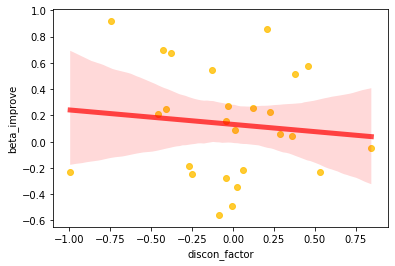

In [86]:
dat = log_reg_discon.loc[log_reg_discon.nrep == 0]
sns.regplot(x=dat["discon_factor"], y=dat["beta_improve"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

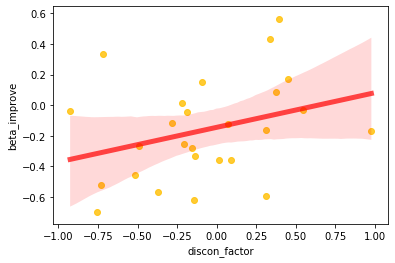

In [87]:
dat = log_reg_discon.loc[log_reg_discon.nrep == 1]
sns.regplot(x=dat["discon_factor"], y=dat["beta_improve"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

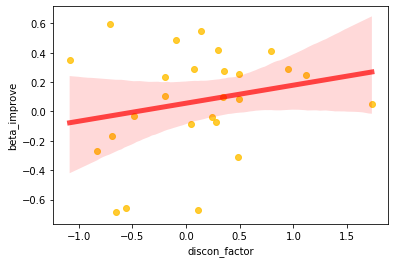

In [88]:
dat = log_reg_discon.loc[log_reg_discon.nrep == 2]
sns.regplot(x=dat["discon_factor"], y=dat["beta_improve"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

In [89]:
log_reg_discon.head()

level_0  index  npar  nrep    weight  discon_factor  discon_bias    Weight  \
0        0      1   1.0     0  0.542069      -0.747203            0  0.915670   
1        1      3   1.0     1  0.892749      -0.720185            0  1.252841   
2        2      5   1.0     2  1.182739       0.486361            0  0.939559   
3        3      7   2.0     0  0.985170      -0.407524            0  1.188932   
4        4      9   2.0     1  0.500627      -0.143216            0  0.572235   

   weightPREV  beta_improve  
0    0.000000      0.915670  
1    0.915670      0.337171  
2    1.252841     -0.313282  
3    0.939559      0.249373  
4    1.188932     -0.616697

<font size="4"> Statistical tests for Beta Weight

In [90]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              nrep  2.924210      2     50  1.462105  5.868840  0.005134   
1         cong_deci  0.127777      1     25  0.127777  0.481839  0.493991   
2  nrep * cong_deci  0.196411      2     50  0.098206  0.313723  0.732149   

   p-GG-corr       np2       eps  
0   0.005689  0.190122  0.965514  
1   0.493991  0.018909  1.000000  
2   0.704928  0.012393  0.881378

In [91]:
dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2),:]
pg.pairwise_ttests(dv='weight', within= ['cond', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast cond  A  B Paired  Parametric         T   dof       Tail  \
0              cond    -  C  D   True        True  1.967996  25.0  two-sided   
1         cong_deci    -  C  I   True        True -0.742887  25.0  two-sided   
2  cond * cong_deci    C  C  I   True        True -0.942407  25.0  two-sided   
3  cond * cong_deci    D  C  I   True        True -0.188948  25.0  two-sided   

      p-unc    p-corr p-adjust   BF10     cohen  
0  0.060254       NaN      NaN  1.091  0.566349  
1  0.464474       NaN      NaN  0.266 -0.211863  
2  0.355003  0.710006     bonf   0.31 -0.278619  
3  0.851659  1.000000     bonf  0.211 -0.048300

In [92]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0       nrep  0  1    True        True  0.651027  25.0  two-sided  0.520969   
1       nrep  0  2    True        True -0.986914  25.0  two-sided  0.333141   
2       nrep  1  2    True        True -1.415148  25.0  two-sided  0.169362   
3  cong_deci  C  I    True        True  0.628396  25.0  two-sided  0.535444   

     p-corr p-adjust   BF10     cohen  
0  1.000000     bonf  0.251  0.153294  
1  0.999422     bonf  0.322 -0.259341  
2  0.508085     bonf  0.503 -0.379305  
3       NaN      NaN  0.248  0.176781

<font size="4"> Statistical tests for Beta Weight <font size="2"> Cardinal & Diagonal together

In [93]:
dat = log_reg_cong_deci_all.loc[log_reg_cong_deci_all.nrep == 2
                    ]

pg.rm_anova(dv = 'weight', within = ['cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc       np2  eps
0  cong_deci  0.117676   1  0.117676  0.551881  0.464474  0.021598  1.0
1      Error  5.330693  25  0.213228       NaN       NaN       NaN  NaN

In [94]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

aovrm = AnovaRM(depvar  = 'weight', data = dat, within = ['nrep','cong_deci'], subject = 'npar')
res = aovrm.fit()

print(res)

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
nrep               nan 0.0000  0.0000    nan
cong_deci       0.5519 1.0000 25.0000 0.4645
nrep:cong_deci     nan 0.0000  0.0000    nan



C:\Users\Angel\Anaconda3\lib\site-packages\statsmodels\stats\anova.py:591: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Angel\Anaconda3\lib\site-packages\statsmodels\stats\anova.py:601: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Angel\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\Users\Angel\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\Users\Angel\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

C:\Users\Angel\Anaconda3\lib\site-packages\statsmodels\stats\anova.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



<font size="5"> _Figure 6B. Intercept for Categorical similarity between stimuli samples and previous decisions._

In [95]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=True, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal',marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=9,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))
fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Intercept (a.u.)", 
                  font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", 
                              font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-4, 5]); fig['layout']['yaxis2'].update(range=[-4, 5])
fig['layout']['yaxis3'].update(range=[-4, 5.034])

fig.show()

<font size="4"> Statistical tests for Intercept

In [96]:
# Cardinal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0              nrep    0.712657      2     50    0.356328    2.367564   
1         cong_deci  196.161515      1     25  196.161515  282.231808   
2  nrep * cong_deci   68.467261      2     50   34.233630  132.287487   

          p-unc     p-GG-corr       np2       eps  
0  1.041350e-01  1.063011e-01  0.086510  0.964722  
1  3.949727e-15  3.949727e-15  0.918628  1.000000  
2  1.074350e-20  2.986206e-16  0.841055  0.758536

In [97]:
# Diagonal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0              nrep    0.666424      2     50    0.333212    2.888894   
1         cong_deci  183.603537      1     25  183.603537  345.238227   
2  nrep * cong_deci   72.417101      2     50   36.208551  161.974774   

          p-unc     p-GG-corr       np2       eps  
0  6.497077e-02  6.765376e-02  0.103586  0.956097  
1  3.809660e-16  3.809660e-16  0.932476  1.000000  
2  1.425361e-22  2.090941e-16  0.866292  0.695875

In [98]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

0.3681603901790538

In [99]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric          T   dof       Tail  \
0       nrep  0  1    True        True   2.196780  25.0  two-sided   
1       nrep  0  2    True        True   1.566225  25.0  two-sided   
2       nrep  1  2    True        True  -0.331109  25.0  two-sided   
3  cong_deci  C  I    True        True -16.799756  25.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  3.752485e-02  0.112575     bonf      1.587  0.417594  
1  1.298676e-01  0.389603     bonf      0.609  0.347636  
2  7.433212e-01  1.000000     bonf      0.218 -0.071594  
3  3.949727e-15       NaN      NaN  1.487e+12 -5.048779

<font size="5"> _Figure 7. β Weight by Incongruent Samples minus β Weight by Congruent Samples divided by Ambiguous and Unambiguous samples and by Conditions._

- Ambiguous (DV = -0.3 to 0.3)
- Unambiguous (DV = 1 to -0.3 and 0.3 to 1)

<font size="3"> _Logisitc regression model to plot Figure 7_

In [100]:
new_dflong = dflong

n_par = np.unique(new_dflong.npar)   #pre_deci
n_bins= np.array([-0.60, 0, 0.60])
log_reg_cong_bins = pd.DataFrame([]) # concatenate participants

formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

npar  nrep cond cong_deci bins  level_5  intercept    weight       PSE
0   1.0     0    C         C -0.6        0   0.503901  1.492892 -0.337533
1   1.0     0    C         I -0.6        0   1.182044  2.266839 -0.521450
2   1.0     1    C         C -0.6        0  -1.262664  2.595462  0.486489
3   1.0     1    C         I -0.6        0   1.631289  0.709234 -2.300071
4   1.0     2    C         C -0.6        0  -2.767297  0.863476  3.204833
5   1.0     2    C         I -0.6        0   5.229062  4.213535 -1.241015
6   1.0     0    C         C  0.0        0   0.517886  0.360623 -1.436090
7   1.0     0    C         I  0.0        0   0.345527  1.430743 -0.241502
8   1.0     0    D         C  0.0        0   0.395480  0.433650 -0.911979
9   1.0     0    D         I  0.0        0   0.819972 -1.148232  0.714117

In [101]:
# first step: coding the new necessary variables  
# to substract β Weight in Congruent Samples to β Weight in Incongruent Samples

log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']

log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

npar  nrep cond cong_deci bins  level_5  intercept  intercept-1      bias  \
0   1.0     0    C         C -0.6        0   0.503901     0.000000  0.503901   
1   1.0     0    C         I -0.6        0   1.182044     0.503901  0.678143   
2   1.0     1    C         C -0.6        0  -1.262664     1.182044 -2.444708   
3   1.0     1    C         I -0.6        0   1.631289    -1.262664  2.893953   
4   1.0     2    C         C -0.6        0  -2.767297     1.631289 -4.398586   

     weight     slope  weight-1       PSE  
0  1.492892  1.492892  0.000000 -0.337533  
1  2.266839  0.773947  1.492892 -0.521450  
2  2.595462  0.328622  2.266839  0.486489  
3  0.709234 -1.886228  2.595462 -2.300071  
4  0.863476  0.154242  0.709234  3.204833

In [102]:
# second step: drop unnecessary columns 
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 
                                                    'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

npar  nrep cond bins      bias     slope
1   1.0     0    C -0.6  0.678143  0.773947
3   1.0     1    C -0.6  2.893953 -1.886228
5   1.0     2    C -0.6  7.996359  3.350058
7   1.0     0    C  0.0 -0.172359  1.070120
9   1.0     0    D  0.0  0.424492 -1.581882

In [103]:
# third step: convert the variable "bins" in a categorical variable
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

npar  nrep cond        bins      bias     slope
1   1.0     0    C  not_ambigu  0.678143  0.773947
3   1.0     1    C  not_ambigu  2.893953 -1.886228
5   1.0     2    C  not_ambigu  7.996359  3.350058
7   1.0     0    C      ambigu -0.172359  1.070120
9   1.0     0    D      ambigu  0.424492 -1.581882

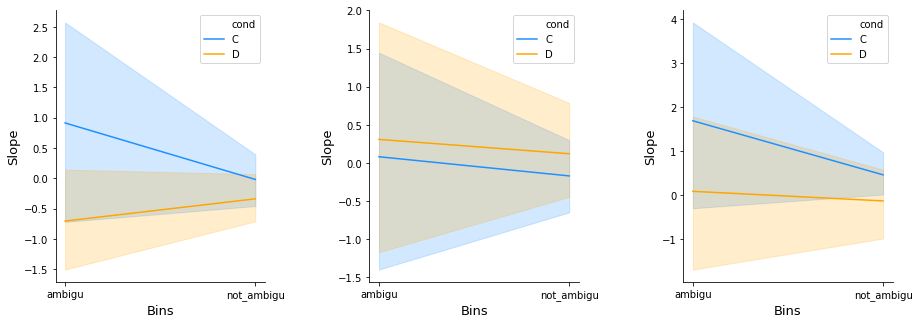

In [104]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

In [105]:
# final step: plot the data
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], opacity = 0.8, x=dat['bins'], boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], boxpoints='all', showlegend=False, opacity = 1,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=3) 

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], 
                 ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Beta weight Incong. - Beta weight Cong. (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif", size=13, color="#424242")))

fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

<font size="4"> _Statistical tests_

Test whether differences in weight between congruent and incongruent samples with previous decisions depend by the ambiguity of the stimuli sample. 

<font size="2"> _t-test for unambiguous_

In [106]:
# t test for Cardinal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -0.0809   25  two-sided  0.9361  [-0.49, 0.46]   0.0159  0.208  0.0507

In [107]:
# t test for Cardinal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -0.7136   25  two-sided  0.4821  [-0.67, 0.32]   0.1399  0.261  0.1055

In [108]:
# t test for Cardinal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d  BF10   power
T-test  1.7544   25  two-sided  0.0916  [-0.08, 1.0]   0.3441  0.79  0.3926

In [109]:
# t test for Diagonal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -1.6461   25  two-sided  0.1123  [-0.76, 0.09]   0.3228  0.678  0.3533

In [110]:
# t test for Diagonal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  0.3819   25  two-sided  0.7058  [-0.53, 0.77]   0.0749  0.222  0.0656

In [111]:
# t test for Diagonal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -0.3379   25  two-sided  0.7383  [-0.95, 0.69]   0.0663  0.218  0.0622

<font size="2"> _t-test for ambiguous_

In [112]:
# t test for Cardinal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test  1.0373   25  two-sided  0.3095  [-0.9, 2.73]   0.2034  0.337  0.1695

In [113]:
# t test for Cardinal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  0.1067   25  two-sided  0.9159  [-1.47, 1.63]   0.0209  0.208  0.0512

In [114]:
# t test for Cardinal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep == 2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  1.5256   25  two-sided  0.1396  [-0.59, 3.96]   0.2992  0.578  0.3114

In [115]:
# t test for Diagonal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test -1.6166   25  two-sided  0.1185  [-1.6, 0.19]    0.317  0.652  0.3428

In [116]:
# t test for Diagonal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  0.39   25  two-sided  0.6998  [-1.32, 1.93]   0.0765  0.222  0.0663

In [117]:
# t test for Diagonal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test  0.0906   25  two-sided  0.9285  [-1.8, 1.97]   0.0178  0.208  0.0509

Post-hoc t-test: one chunck for each presentation

In [118]:
# post-hoc t-test for P1
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==0]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True -0.588406   
1         cond           -           C       D   True        True  2.164680   
2  bins * cond  not_ambigu           C       D   True        True  0.889766   
3  bins * cond      ambigu           C       D   True        True  1.710311   

    dof       Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  25.0  two-sided  0.561539       NaN      NaN  0.243 -0.149773  
1  25.0  two-sided  0.040161       NaN      NaN  1.503  0.528117  
2  25.0  two-sided  0.382074  0.764147     bonf  0.297  0.286906  
3  25.0  two-sided  0.099593  0.199185     bonf  0.742  0.456812

In [119]:
# post-hoc t-test for P2
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==1]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True -0.413124   
1         cond           -           C       D   True        True -0.444592   
2  bins * cond  not_ambigu           C       D   True        True -0.761797   
3  bins * cond      ambigu           C       D   True        True -0.199749   

    dof       Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  25.0  two-sided  0.683037       NaN      NaN  0.224 -0.109050  
1  25.0  two-sided  0.660440       NaN      NaN  0.227 -0.123173  
2  25.0  two-sided  0.453309  0.906617     bonf   0.27 -0.204310  
3  25.0  two-sided  0.843293  1.000000     bonf  0.211 -0.057843

In [120]:
# post-hoc t-test for P3
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True -1.016725   
1         cond           -           C       D   True        True  1.473674   
2  bins * cond  not_ambigu           C       D   True        True  1.282360   
3  bins * cond      ambigu           C       D   True        True  1.106035   

    dof       Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  25.0  two-sided  0.319023       NaN      NaN   0.33 -0.266928  
1  25.0  two-sided  0.153051       NaN      NaN  0.541  0.396730  
2  25.0  two-sided  0.211480  0.422960     bonf  0.432  0.345104  
3  25.0  two-sided  0.279242  0.558484     bonf  0.359  0.309864

In [121]:
df['change'] = 1
df.loc[(df.pre_deci == 0) & (df.deci == 0) | (df.pre_deci == 1) & (df.deci == 1), 'change'] = 0
df.head()

npar           subj  nblock  ntrial  nrep  cond       DV resp  deci  r_map  \
0   1.0  020621150004E       0       0     0     1  0.16667    m     1      0   
1   1.0  020621150004E       0       0     2     1  0.16667    m     0     45   
2   1.0  020621150004E       0       1     0     1  0.06667    m     1      0   
3   1.0  020621150004E       0       1     1     1  0.06667    m     1      0   
4   1.0  020621150004E       0       1     2     1  0.06667    z     0      0   

        rDV  pre_deci  first_deci   pre_RTz  2pre_RTz  pre_correct  correct  \
0  0.185048         0           0  0.000000  0.000000            0        1   
1  0.178250         0           1  3.783534  1.237713            0        0   
2  0.050171         0           0  0.875352  3.783534            0        1   
3  0.089799         1           0  0.889289  0.875352            1        1   
4  0.049998         1           1 -0.118819  0.889289            1        0   

      RT        d1        d2        d3        d4        d5        d6     o1  \
0  1.646 -0.022671  0.566085 -0.622602  0.398017  0.095505  0.695955  1.187   
1  1.412  0.711753  0.784045 -0.302265 -0.435200  0.583391 -0.272226  2.243   
2  1.421  0.066975 -0.660800  0.452012  0.134692  0.851809 -0.543662  0.419   
3  0.770 -0.063414  0.780508  0.771831 -0.761668 -0.717859  0.529397  1.203   
4  0.257 -0.977082  0.201938  0.505488 -0.185127 -0.104677  0.859448  0.009   

      o2     o3     o4     o5     o6  pre_cond       RTz     1/RTz  change  
0  0.615  1.719  0.549  2.001  0.666         0  1.237713 -0.274395       1  
1  2.441  0.274  1.349  0.949  1.285         1  0.875352 -0.242168       0  
2  1.704  2.141  2.696  2.298  1.750         1  0.889289 -0.243604       1  
3  2.270  0.875  3.048  1.460  2.541         1 -0.118819 -0.053160       0  
4  0.472  2.162  0.320  2.790  2.301         1 -0.913227  0.776621       1

In [122]:
p1 = df.loc[df.nrep == 0]
print('p1')
print(p1['change'].mean())
print('p2')
p2 = df.loc[df.nrep == 1]
print(p2['change'].mean())
print('p3')
p3 = df.loc[df.nrep == 2]
print(p3['change'].mean())

p1
0.4303861788617886
p2
0.194778426657506
p3
0.15098661028893587
